---
date: 13-01-2025
author: Martin Proks
title: Human scANVI fix
---

Re-training of human model due to an estimation bug in `scvi-tools`. For more info see [summary here](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/scanvi_fix.html).

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.1.5/bin/pip


In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
from rich import print
from scipy import sparse

plt.rcParams['svg.fonttype'] = 'none'

lineage_colors = {
    'Oocyte': '#000000',
    'Zygote': '#7985A5',
    'Pronucleus': '#555d73',
    'Prelineage': '#7985A5',
    '2C': '#B3C81E',
    '4C': '#67BB30',
    '8C': '#028A46',
    'Morula': '#657cbd',
    'ICM': '#F6C445',
    'TE': '#5a94ce',
    'EPI': '#B46F9C',
    'PrE': '#D05B61',
}

ct_colors = {
    'Prelineage': '#7985A5',
    '8C_3.0': '#028A46',
    'Morula_4.0': '#657cbd',
    'Inner Cell Mass': '#F6C445',
    'Primitive Endoderm': '#D05B61',
    'Epiblast_6.0': '#d6b2ca',
    'Epiblast_7.0': '#c38db1',
    'Late epiblast': '#aa5c8f',
    'Trophectoderm_5.0': '#cddff0',
    'Trophectoderm_6.0': '#bdd4eb',
    'Trophectoderm_7.0': '#acc9e6',
    'Trophectoderm_8.0': '#9cbfe2',
    'Trophectoderm_9.0': '#8bb4dd',
    'Trophectoderm_10.0': '#5a94ce',
}

In [4]:
os.sys.path.append('../scripts/')
from helpers import plot_cv

In [5]:
human = sc.read_h5ad("../data/processed/32_human_adata.h5ad")
human.obs.experiment = human.obs.experiment.str.replace('_', ' et al., ').astype('category')
human.obs['batch'] = human.obs.experiment

human.obs['timepoint'] = human.obs.ct.astype(str)
timepoint_mask = human.obs.ct.isin(['Unknown', 'Trophectoderm', 'Inner Cell Mass', 'Primitive Endoderm', 'Epiblast'])
human.obs.loc[timepoint_mask, 'timepoint'] = 'E' + human.obs.loc[timepoint_mask, 'day'].astype(str)
human.obs.ct = human.obs.ct.astype('category')
human.obs['ct_orig'] = human.obs.ct

ENSG_to_SYMBOL = pd.read_csv('../data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL.tsv', delimiter=" ", header=None)
ENSG_to_SYMBOL.columns = ['ensembl','symbol']
ENSG_to_SYMBOL_noName = pd.read_csv('../data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL_noName.tsv', delimiter=" ", header=None)
nameless_df = pd.DataFrame(
    data = {
        'ensembl' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
        'symbol' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
    })
ENSG_to_SYMBOL = pd.concat([ENSG_to_SYMBOL, nameless_df])
ENSG_to_SYMBOL.set_index('ensembl', inplace=True)

human.var['symbol'] = ENSG_to_SYMBOL.loc[human.var_names, 'symbol']

# remove mitochondrial genes
human = human[:, human.var[~human.var.symbol.str.startswith('MT-')].index].copy()

# remove ribosomal genes
human = human[:, human.var[~human.var.symbol.str.startswith(('RPS', 'RPL'))].index].copy()

In [6]:
# Using correct annotations after renaming
human.obs.ct = sc.read_h5ad('../results/02_human_integration/05_scanvi_ns15/adata.h5ad').obs['C_scANVI_nsamples'].values
human.obs.ct = human.obs.ct.cat.reorder_categories([
    'Prelineage', '8C_3.0', 'Morula_4.0',
    'Inner Cell Mass',
    'Primitive Endoderm',
    'Epiblast_6.0', 'Epiblast_7.0', 'Late epiblast',
    'Trophectoderm_5.0', 'Trophectoderm_6.0', 'Trophectoderm_7.0',
    'Trophectoderm_8.0', 'Trophectoderm_9.0', 'Trophectoderm_10.0'])

# Update stages
human.obs['stage'] = human.obs.ct.str.split('_', expand=True)[0].replace({
    'Epiblast': 'EPI',
    'Late epiblast': 'EPI',
    'Inner Cell Mass': 'ICM',
    'Primitive Endoderm': 'PrE',
    'Trophectoderm': 'TE'
}).astype('category')
human.obs.stage = human.obs.stage.cat.reorder_categories(['Prelineage', '8C', 'Morula', 'TE', 'ICM', 'EPI', 'PrE'])

In [7]:
sc.pp.highly_variable_genes(
    human,
    flavor="cell_ranger",
    n_top_genes=3_000,
    batch_key="batch",
    subset=True,
)

In [13]:
human.uns['ct_colors'] = [ct_colors[x] for x in human.obs.ct.cat.categories]
human.uns['stage_colors'] = [lineage_colors[x] for x in human.obs.stage.cat.categories]

## 1. scVI

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 274/400:  68%|██████▊   | 274/400 [00:39<00:18,  6.97it/s, v_num=1, train_loss_step=3.88e+3, train_loss_epoch=3.82e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 4358.733. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

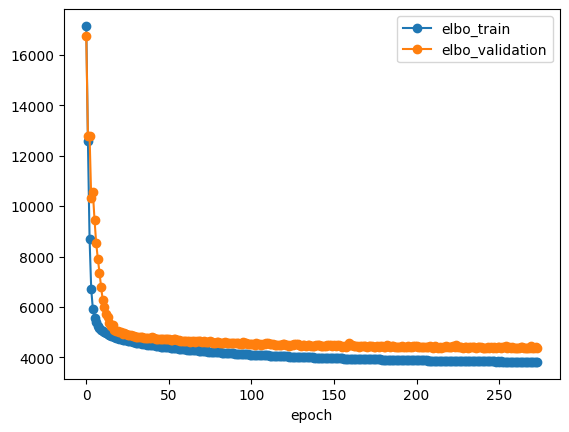

In [14]:
scvi.model.SCVI.setup_anndata(human, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(human, n_layers=2, gene_likelihood='nb')
vae.train(max_epochs=400, early_stopping=True)
pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line(marker='o')

In [15]:
vae.save("../results/15_scANVI_fix/human/scvi", overwrite=True, save_anndata=True)

## 2. scANVI

In [16]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata=human, labels_key="ct", unlabeled_category="Unknown")
lvae.train(max_epochs=20, n_samples_per_label=15)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Epoch 20/20: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s, v_num=1, train_loss_step=3.85e+3, train_loss_epoch=3.83e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:06<00:00,  2.87it/s, v_num=1, train_loss_step=3.85e+3, train_loss_epoch=3.83e+3]


In [17]:
lvae.save("../results/15_scANVI_fix/human/scanvi_ns15", overwrite=True, save_anndata=True)

## 3. PPC

In [18]:
from scvi.criticism import PosteriorPredictiveCheck

Some random problem, possible solved in [cf0af33](https://github.com/scverse/scvi-tools/commit/cf0af3385de0715a07960a56b13eaae042bad0f5).

> [!CAUTION]
> ValueError: coordinate cells has dimensions ('index',), but these are not a subset of the DataArray dimensions ('cells', 'features', 'samples')

In [20]:
# ppc = PosteriorPredictiveCheck(human, 
#                                models_dict={'SCVI': vae, 'SCANVI': lvae}, 
#                                count_layer_key='counts')

# ppc.coefficient_of_variation(dim='cells')
# ppc.coefficient_of_variation(dim='features')

In [21]:
# fig, ax = plt.subplots(1, 2, figsize=[10, 3])
# plot_cv(ppc, 'SCVI', 'cv_gene', ax=ax[0])
# plot_cv(ppc, 'SCVI', 'cv_cell', ax=ax[1])

# fig, ax = plt.subplots(1, 2, figsize=[10, 3])
# plot_cv(ppc, 'SCANVI', 'cv_gene', ax=ax[0])
# plot_cv(ppc, 'SCANVI', 'cv_cell', ax=ax[1])

## 4. Benchmarker

In [22]:
from scib_metrics.benchmark import Benchmarker

In [23]:
sc.tl.pca(human)

In [24]:
human.obsm['X_scVI'] = vae.get_latent_representation()
human.obsm['X_scANVI'] = lvae.get_latent_representation()

In [25]:
bm = Benchmarker(
    human,
    batch_key="batch",
    label_key="ct",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI"],
    n_jobs=6,
)
bm.benchmark()

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings: 100%|██████████| 3/3 [00:43<00:00, 14.38s/it]


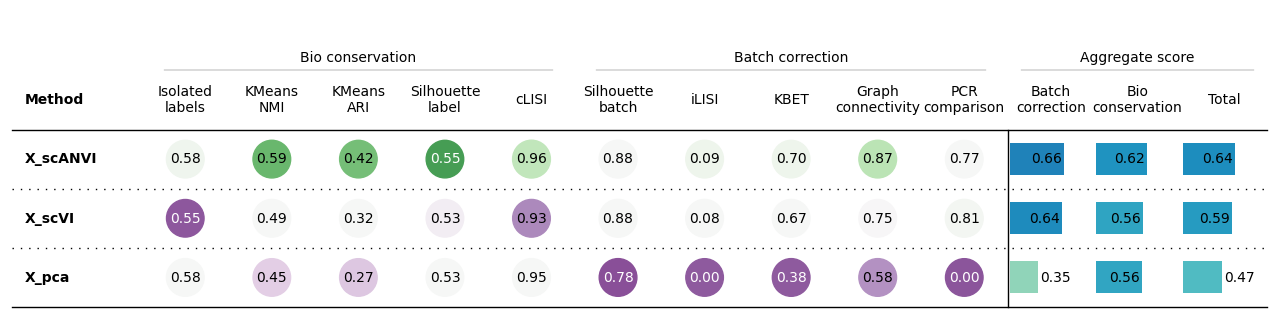

In [26]:
bm.plot_results_table(min_max_scale=False, save_dir='../results/15_scANVI_fix/human/')

## 5. Downstream analysis

In [27]:
lvae.adata.obsm['X_scVI'] = human.obsm['X_scVI']
lvae.adata.obsm['X_scANVI'] = human.obsm['X_scANVI']
lvae.adata.layers['scANVI_normalized'] = sparse.csr_matrix(lvae.get_normalized_expression(return_mean=True))

In [28]:
sc.tl.pca(lvae.adata)
sc.pp.neighbors(lvae.adata, use_rep='X_scANVI')
sc.tl.leiden(lvae.adata, resolution=0.8)
sc.tl.umap(lvae.adata)
sc.tl.draw_graph(lvae.adata, n_jobs=6)

/scratch/temp/fdb589/ipykernel_1242893/2187811291.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(lvae.adata, resolution=0.8)


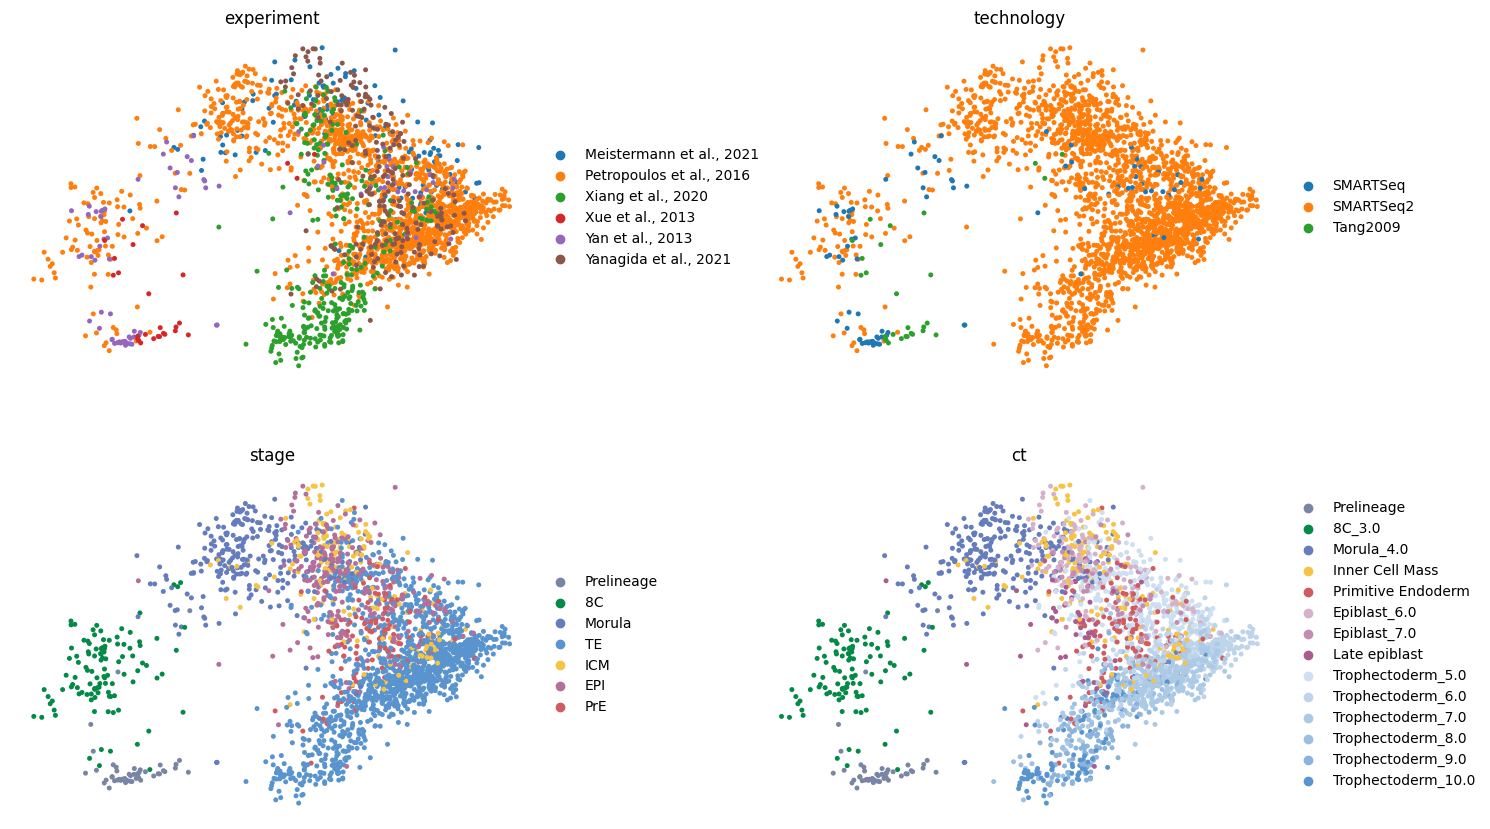

In [29]:
sc.pl.pca(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

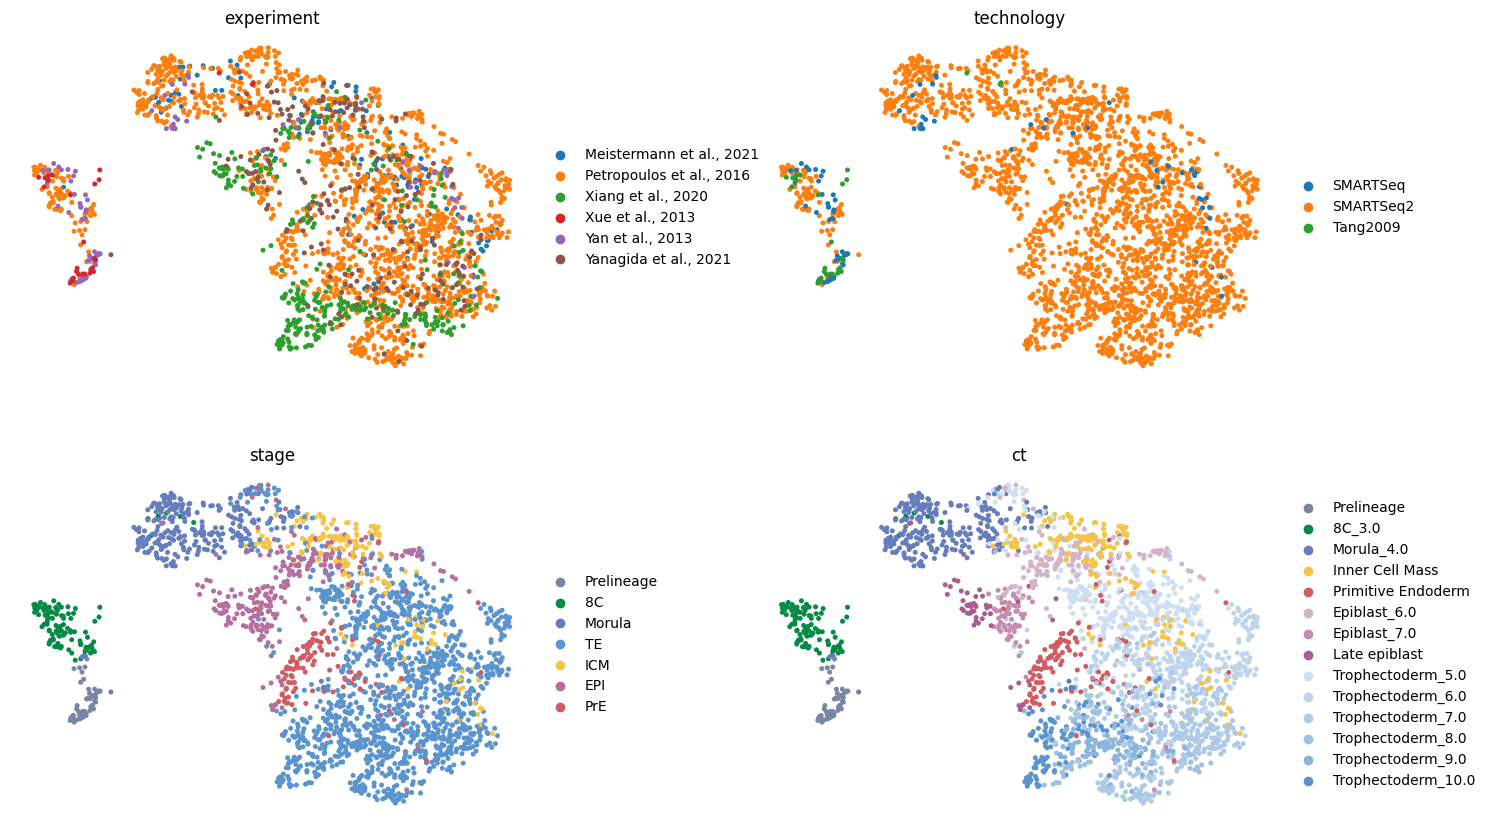

In [30]:
sc.pl.umap(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

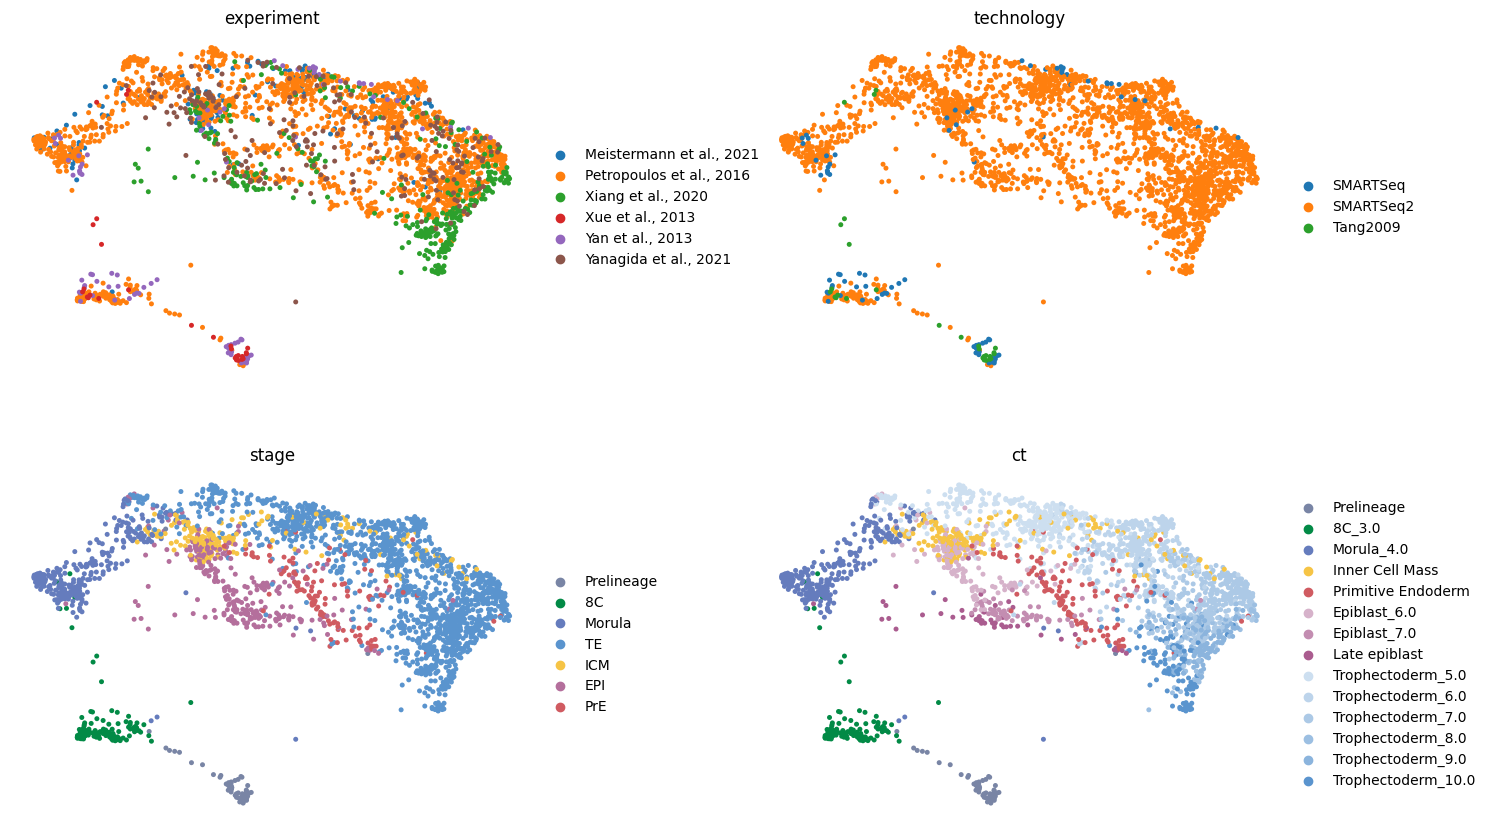

In [31]:
sc.pl.draw_graph(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

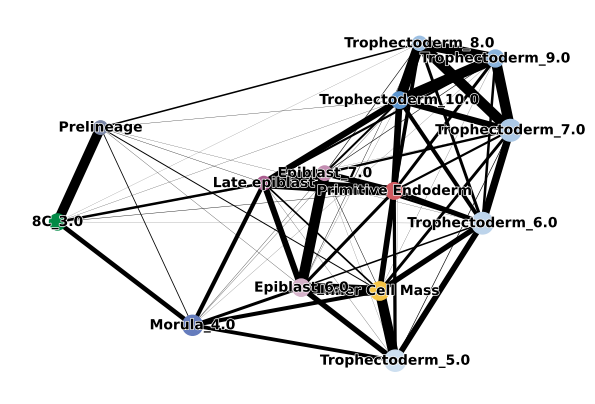

In [32]:
sc.pp.neighbors(lvae.adata, use_rep='X_scANVI')
sc.tl.diffmap(lvae.adata)

sc.tl.paga(lvae.adata, groups='ct')
sc.pl.paga(lvae.adata, color=['ct'], frameon=False, fontoutline=True)
sc.tl.draw_graph(lvae.adata, init_pos='paga', n_jobs=6)

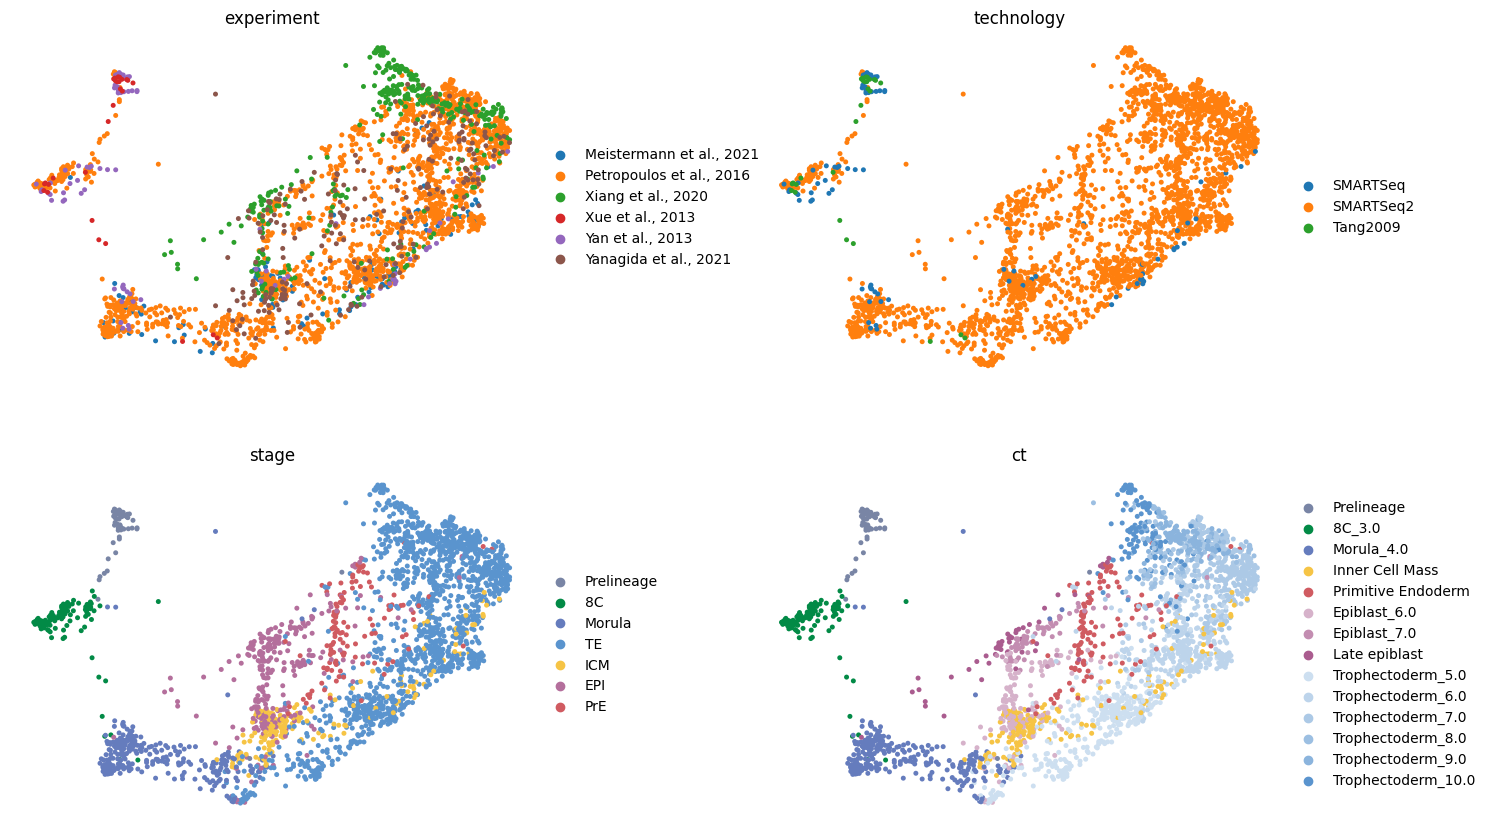

In [33]:
sc.pl.draw_graph(lvae.adata, color=['experiment', 'technology', 'stage', 'ct'], frameon=False, ncols=2, wspace=0.3)

## 6. DEGs

In [34]:
sc.tl.rank_genes_groups(lvae.adata, groupby='stage', key_added='degs_by_stage')
sc.tl.rank_genes_groups(lvae.adata, groupby='ct', key_added='degs_by_ct')

## 7. Cell Type prediction

In [35]:
lvae.adata.obs['predictions'] = lvae.predict()
lvae.adata.obs['entropy'] = 1 - lvae.predict(soft=True).max(axis=1)

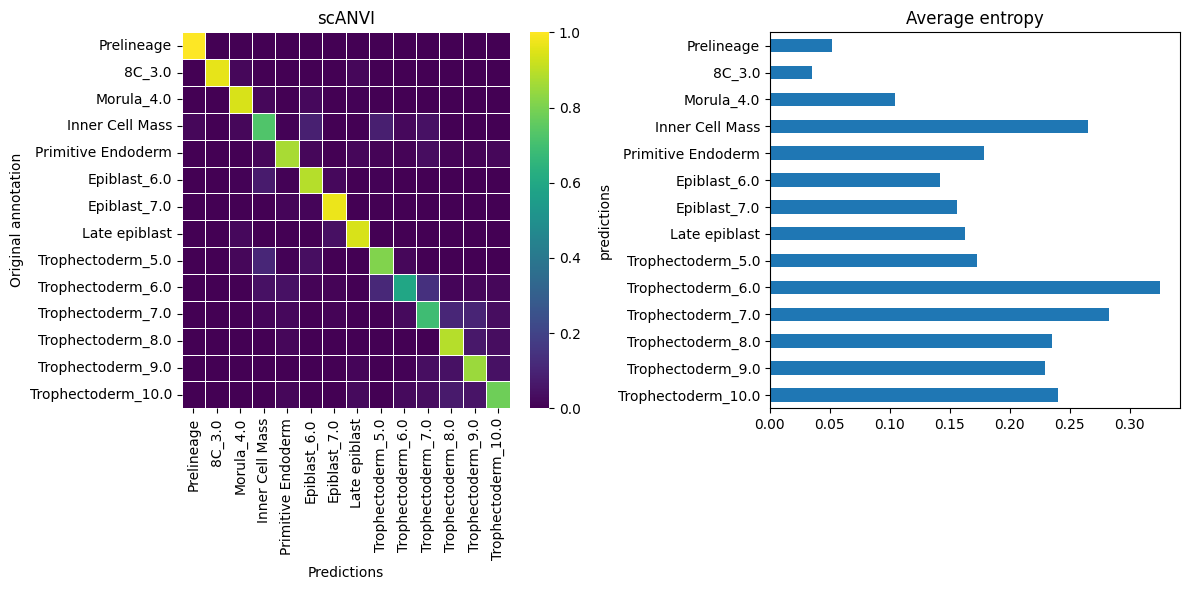

In [40]:
mtx_oder = lvae.adata.obs.ct.cat.categories.tolist()
mtx = sc.metrics.confusion_matrix("ct", "predictions", lvae.adata.obs).loc[mtx_oder, mtx_oder]
entropy = lvae.adata.obs.groupby(['predictions']).mean(numeric_only=True)['entropy'][mtx_oder]

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
sns.heatmap(mtx, cmap='viridis', linewidths=0.5, vmax=1, ax=ax[0]).set(xlabel='Predictions', ylabel='Original annotation', title='scANVI')
entropy[::-1].plot.barh(ax=ax[1], title='Average entropy')
fig.tight_layout()

In [41]:
print(
    f'Accuracy score: {accuracy_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values)}\n'
    f'Balanced accuracy: {balanced_accuracy_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values)}\n'
    f'F1 (micro): {f1_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values, average="micro")}\n'
    f'F1 (macro): {f1_score(lvae.adata.obs.ct.values, lvae.adata.obs.predictions.values, average="macro")}'
)

Accuracy score: 0.7968144640551011
Balanced accuracy: 0.8502734650790613
F1 (micro): 0.7968144640551011
F1 (macro): 0.8150578255414443

## 8. scANVI explainer

In [42]:
from scanvi_explainer import SCANVIBoostrapper

In [43]:
bootstrapper = SCANVIBoostrapper(lvae, n_bootstraps=10)

In [44]:
shap_values = bootstrapper.run(train_size=0.8, batch_size=64)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [45]:
bootstrapper.save(shap_values, '../results/15_scANVI_fix/human/bootstrapped_shaps.feather')

### 8.1. Filter explainer results

In [46]:
df = pd.read_feather('../results/15_scANVI_fix/human/bootstrapped_shaps.feather').set_index('index')
mask = df[df.columns[:-1]].mean(axis=1) > 0.01

df_filtered = df[mask].copy()

In [47]:
df_filtered

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,label
index,,,,,,,,,,,
ENSG00000117148,2237.541877,2697.301849,2234.120986,2208.844262,2002.162609,2295.789959,2855.422668,1396.265935,2036.107064,2295.913209,Prelineage
ENSG00000183508,983.723201,810.153552,420.326658,747.120575,649.999358,670.018545,968.188527,333.453627,555.598256,725.772129,Prelineage
ENSG00000248485,249.753499,289.067029,194.462396,232.048960,228.989517,217.526254,240.465800,134.438408,275.763678,228.687957,Prelineage
ENSG00000162592,110.195010,115.607549,93.488128,90.564197,104.951220,96.097708,128.278758,67.118113,116.426465,121.582138,Prelineage
ENSG00000185155,86.450475,81.950838,58.085818,69.691882,81.403664,69.425090,87.825787,47.010987,88.107272,71.621482,Prelineage
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285641,0.031572,0.020698,0.015395,0.007929,0.038507,0.030249,0.017398,0.006801,0.007815,0.009424,Trophectoderm_10.0
ENSG00000200087,0.030518,0.009487,0.000474,0.059709,0.000136,0.003693,0.009135,0.018600,0.015880,0.015842,Trophectoderm_10.0
ENSG00000203724,0.010410,0.003683,0.023687,0.002489,0.012516,0.006961,0.027898,0.006312,0.013267,0.002878,Trophectoderm_10.0


In [48]:
lvae.adata.uns['explainer'] = {
    'bootstrapper': {
        'n_bootstraps': 10,
        'train_size': 0.8,
        'batch_size': 64,
        'shap_values': df_filtered
    }
}

## 9. Save results

In [54]:
lvae.adata.write('../results/15_scANVI_fix/human/scanvi_ns15/adata.h5ad')

In [55]:
!du -h ../results/15_scANVI_fix/human/scanvi_ns15/adata.h5ad

313M	../results/15_scANVI_fix/human/scanvi_ns15/adata.h5ad


/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
